In [1]:
import numpy as np
import pygplates
import matplotlib.pyplot as plt

import gprm.utils.paleogeography as pg
from gprm.utils.spatial import plate_boundary_intersections
from gprm.datasets import Reconstructions
from gprm import GPlatesRaster


In [2]:
#reconstruction_model = Reconstructions.fetch_Young2019()
#seafloor_age_grid_template = '/Users/simon/GIT/agegrid-0.1/grid_files/masked/Y19_seafloor_age_mask_{:0.1f}Ma.nc'

reconstruction_model = Reconstructions.fetch_Matthews2016()
seafloor_age_grid_template = '/Users/simon/GIT/agegrid-0.1/grid_files/masked/M16_seafloor_age_mask_{:0.1f}Ma.nc'



In [37]:
PtLons = [30,130]
PtLats = [-60,55]

# derive a great-circle profile lines from the anchor points
GreatCirclePoints,ProfilePoints,arc_distance = pg.create_profile_points(PtLons,PtLats)

# create an array of distances along profile in km, starting at zero
ProfileX_kms = np.arange(0,ProfilePoints.shape[0])*arc_distance

cross_section_geometry = pygplates.PolylineOnSphere(GreatCirclePoints)

In [38]:
reconstruction_time = 125.

plate_snapshot = reconstruction_model.plate_snapshot(reconstruction_time)
seafloor_age_grid = GPlatesRaster(seafloor_age_grid_template.format(reconstruction_time))


# Find where the profile line intersects plate boundaries from the resolved topologies
# [TODO - maybe would be better to use the untesselated line segments for this??]
(subduction_intersections,
 ridge_intersections,
 other_intersections) = plate_boundary_intersections(cross_section_geometry,plate_snapshot.resolved_topological_sections,ProfileX_kms)

print('Profile crosses: \n%d subduction zones \n%d Mid-ocean ridges \n%d other boundaries' \
    % (len(subduction_intersections), len(ridge_intersections), len(other_intersections)))

Profile crosses: 
2 subduction zones 
3 Mid-ocean ridges 
0 other boundaries


In [39]:
seafloor_age_profile = seafloor_age_grid.sample_using_gmt(GreatCirclePoints[:,1],GreatCirclePoints[:,0])

seafloor_depth_profile = pg.age2depth(seafloor_age_profile)/1000
seafloor_litho_thickness = np.sqrt(seafloor_age_profile)

profile_plate_ids = pg.profile_plate_ids(plate_snapshot.resolved_topologies,reconstruction_model.rotation_model,GreatCirclePoints)


grdtrack [INFORMATION]: Processing input grid(s)
grdtrack [INFORMATION]: Reading grid from file /Users/simon/GIT/agegrid-0.1/grid_files/masked/M16_seafloor_age_mask_125.0Ma.nc
grdtrack [INFORMATION]: Set boundary condition for top    edge: geographic
grdtrack [INFORMATION]: Set boundary condition for bottom edge: geographic
grdtrack [INFORMATION]: Reading Data Table from file /var/folders/k2/jz_0twls1q13vbr87bqwdtr40000gn/T/tmpu76sjlxq
grdtrack [INFORMATION]: Writing Data Table to file /var/folders/k2/jz_0twls1q13vbr87bqwdtr40000gn/T/tmpzp1qq62t
grdtrack [INFORMATION]: Sampled 280 points from grid /Users/simon/GIT/agegrid-0.1/grid_files/masked/M16_seafloor_age_mask_125.0Ma.nc (721 x 361)


/Users/Simon/GIT/GPlatesReconstructionModel/gprm/utils/paleogeography.py:411: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xgrid,zgrid,tmp,cmap=plt.cm.inferno_r,vmin=-10,vmax=150)
/Users/Simon/GIT/GPlatesReconstructionModel/gprm/utils/paleogeography.py:414: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xgrid,zgrid,tmp,cmap=cmap,vmin=age_min,vmax=age_max)


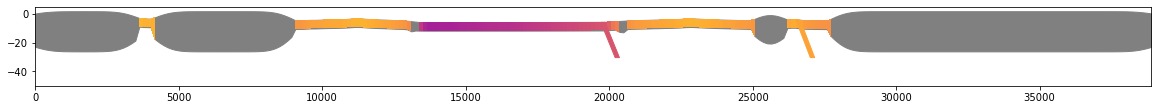

<Figure size 1440x576 with 0 Axes>

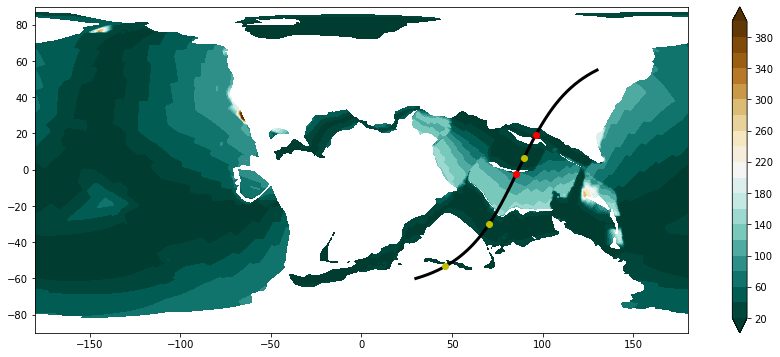

In [40]:
pg.paleo_age_grid_cross_section(ProfileX_kms, profile_plate_ids, 
                                seafloor_age_profile, subduction_intersections,
                                daspect = 50, smoothing_iterations=20,
                                age_min = -50, age_max = 250, cmap=plt.cm.plasma_r)
plt.show()


plt.figure(figsize=(20,8))

seafloor_age_grid.plot()

plt.gca().set_aspect('equal')
plt.plot(GreatCirclePoints[:,1],GreatCirclePoints[:,0],'k',linewidth=3)
for point in subduction_intersections:
    plt.plot(point[0].to_lat_lon()[1],point[0].to_lat_lon()[0],'ro')
for point in ridge_intersections:
    plt.plot(point[0].to_lat_lon()[1],point[0].to_lat_lon()[0],'yo')
for point in other_intersections:
    plt.plot(point[0].to_lat_lon()[1],point[0].to_lat_lon()[0],'go')
plt.show()
